In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import torch

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge
# from kernels import divergence_free_se_kernel, block_diagonal_se_kernel 
from GP import predict, optimise_hypers_on_train
# optimize_hypers_on_train
from metrics import log_likelihood_test

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

/home/kim/eccv/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# X test

In [2]:
# grid discretisation over domain [0, 1] for x1 and x2
N_grid_x1 = 20 + 1 # 21 so steps are easy numbers
N_grid_x2 = N_grid_x1

N_grid = N_grid_x1 * N_grid_x2

x1 = np.linspace(0, 1, N_grid_x1) # x
x2 = np.linspace(0, 1, N_grid_x2) # y

# define distances (for divergence caluclations)
dx = 1 / (N_grid_x1 - 1)
dy = 1 / (N_grid_x2 - 1)

X1_test, X2_test = np.meshgrid(x1, x2)

# grid is not flat, so flatten
X_test_grid = torch.cat([torch.tensor(X1_test).unsqueeze(-1), torch.tensor(X2_test).unsqueeze(-1)], dim = -1)
X_test = X_test_grid.reshape(-1, 2)

# Fixed X train

In [3]:
# Fixed training data points for now
X_train = torch.tensor([
    [0.8750, 0.1500, 0.2500, 0.5000, 0.3853, 0.9991, 0.4333, 0.1494, 0.6196, 0.7808, 0.5609, 0.5895, 0.3395, 0.7232],
    [0.6750, 0.9750, 0.9000, 0.3500, 0.6010, 0.3451, 0.7451, 0.8499, 0.6240, 0.7218, 0.8389, 0.1664, 0.9771, 0.0598]]).T

# Y values

In [4]:
simulation_functions = [simulate_convergence]
# simulation_functions = [simulate_merge]
# simulation_functions = [simulate_branching]

for simulation_func in simulation_functions:

    Y_train = simulation_func(X_train)

    # Noise
    make_some_noise = torch.tensor([0.00]) # reduce to zero to see what is going on
    Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

    # ground truth for metrics
    Y_test = simulation_func(X_test)

In [15]:
Y_test.shape

torch.Size([441, 2])

In [23]:
# Functional view of divergence: trace of the Jacobian
# strategy = 'reverse-mode'
# N is the batch size, 2 is the dimensionality
# J is (N x 2, N x 2): du/dx, du/dy, dv/dx, dv/dy
J = torch.autograd.functional.jacobian(func = simulation_func, inputs = X_test)
# torch.trace
# we only need du/dx and dv/dy
print(lambda x: torch.trace(J(x)))

<function <lambda> at 0x7f73bc162ee0>


In [24]:
def div(u):
    """Accepts a function u:R^D -> R^D."""
    return lambda x: torch.trace(torch.autograd.functional.jacobian(func = u, inputs = X_test))

In [ ]:
def plotVelsTori(u,T,ax1,ax2=None,rf_sols=None):
    N = 250
    a=1
    X,Y = np.meshgrid(np.linspace(0,a,N),np.linspace(0,a,N))
    
    for i,t in enumerate(T):
        pts = jnp.vstack([np.ones(X.reshape(-1).shape)*t,X.reshape(-1),Y.reshape(-1)]).T
        vel = vmap(u)(pts)
        U = np.array(vel[:,0].reshape(X.shape))
        V = np.array(vel[:,1].reshape(Y.shape))
        ax1[i].set_xlim(0,a)
        ax1[i].set_ylim(0,a)
        plt_str = ax1[i].streamplot(X,Y,U,V,density=0.45,arrowsize=4,linewidth=4,color='k')
        ax1[i].axis('off')
        
        rect = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='k', facecolor='none')
        ax1[i].add_patch(rect)
        
        if ax2 is not None:
            rf = rf_sols[i]
            points = np.array(rf.points[:,:2])
            rho_ref = np.array(rf['rho_n'])
            u_ref = np.array(rf['u_n'])

            rho_ref = int_grid(points,rho_ref,(X,Y))
            u_ref = int_grid(points,u_ref,(X,Y))

            ax2[i].set_xlim(0,a)
            ax2[i].set_ylim(0,a)
            #ax[0].plot(bd[0],bd[1])
            U_1 = np.array(u_ref[:,:,0])
            V_1 = np.array(u_ref[:,:,1])
            plt_str = ax2[i].streamplot(X,Y,U_1,V_1,density=0.45,arrowsize=4,linewidth=4,color='k')
            ax2[i].axis('off')

            rect = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='k', facecolor='none')
            ax2[i].add_patch(rect)

## Utility function

In [33]:
def calculate_divergence(UV, dx = 0.05, dy = 0.05, N_grid_x1 = 21, N_grid_x2 = 21):
    # UV is a tensor of shape (N, 2)
    # extract both U and V and reshape to grid
    U_grid = UV[:, 0].reshape(N_grid_x1, N_grid_x2)
    V_grid = UV[:, 1].reshape(N_grid_x1, N_grid_x2)

    U_div = np.gradient(U_grid, dx, axis = 1)
    V_div = np.gradient(V_grid, dy, axis = 0)

    div_grid = U_div + V_div

    return div_grid

In [34]:
calculate_divergence(Y_test).sum()

0.0

# Divergence-free mean

In [40]:
# define mean function
def mean_func_divfree(X):
    # Option one
    # U = torch.ones_like(X[:, 1]) * 2
    # V = X[:, 0]

    # constant mean
    U = torch.ones_like(X[:, 1])
    V = torch.ones_like(X[:, 1])

    return torch.cat([U.unsqueeze(-1), V.unsqueeze(-1)], dim = -1)

mean_divfree = mean_func_divfree(X_test)
train_mean_divfree = mean_func_divfree(X_train)

# assert 
print("Divergence of mean field:", calculate_divergence(mean_divfree).sum())

print("RMSE between mean field and true field: ", torch.sqrt(torch.mean(torch.square(mean_divfree - Y_test))).item())

Divergence of mean field: 0.0
RMSE between mean field and true field:  0.584522597225006


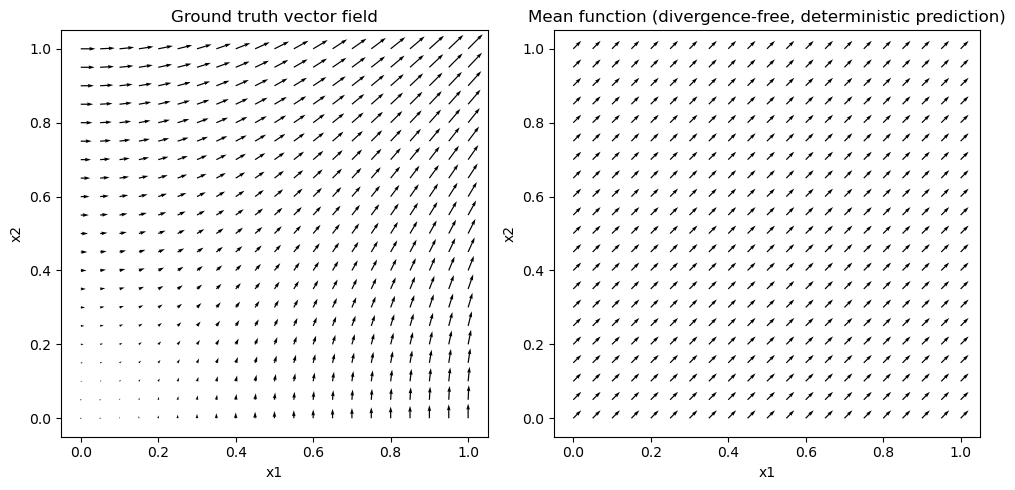

In [41]:
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1, 2, figsize = (10, 5))  # 1 row, 2 columns

axes[0].set_title('Ground truth vector field')
axes[0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black')
# axes[0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# quiver color is determined by the divergence of the vector field
# color argument needs to be flat like the X, Y arguments
divergence = calculate_divergence(mean_divfree).flatten()
max_val = np.max(np.abs(divergence)) + 1 # Find the max absolute value, add one for issue with zeroes
norm = plt.Normalize(vmin = - max_val, vmax = max_val)
# Define a custom colormap from blue to black to red
cmap = mcolors.LinearSegmentedColormap.from_list(
    'blue_black_red', ['blue', 'black', 'red'], N = 256)

axes[1].set_title('Mean function (divergence-free, deterministic prediction)')
# use dark diverging colormap
axes[1].quiver(X_test[:, 0], X_test[:, 1], mean_divfree[:, 0], mean_divfree[:, 1], color = cmap(norm(divergence)))
# axes[1].quiver(X_train[:, 0], X_train[:, 1], train_mean_divfree[:, 0], train_mean_divfree[:, 1], color = "blue")
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Repeat with known divergence

In [10]:
def mean_func_divergent(X):
    U = torch.ones_like(X[:, 1])
    V = X[:, 1]
    # V = X[:, 1]**2
    return torch.cat([U.unsqueeze(-1), V.unsqueeze(-1)], dim = -1)

mean_div = mean_func_divergent(X_test)

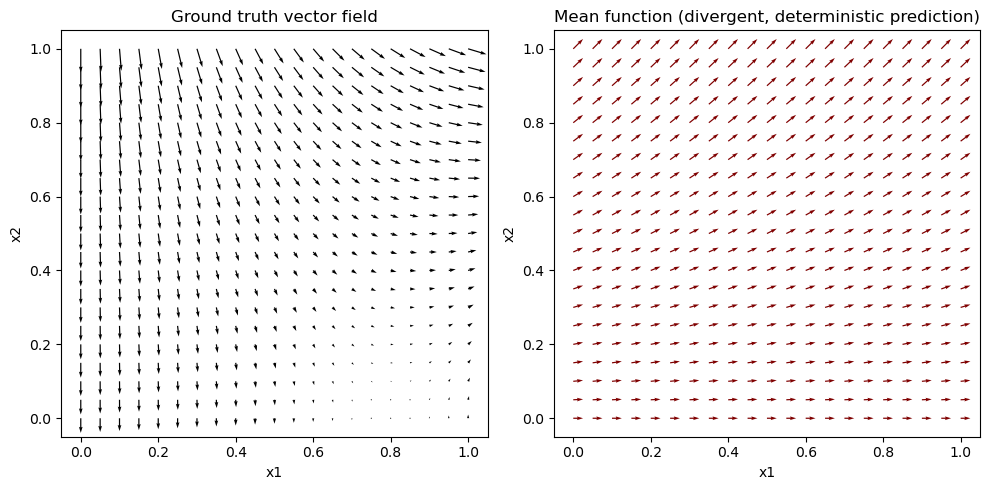

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))  # 1 row, 2 columns

axes[0].set_title('Ground truth vector field')
axes[0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black')
# axes[0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# color argument needs to be flat like the X, Y arguments
divergence = calculate_divergence(mean_div).flatten()
max_val = np.max(np.abs(divergence)) + 1 # Find the max absolute value, add one for issue with zeroes
norm = plt.Normalize(vmin = - max_val, vmax = max_val)
# Define a custom colormap from blue to black to red
cmap = mcolors.LinearSegmentedColormap.from_list(
    'blue_black_red', ['blue', 'black', 'red'], N = 256)

axes[1].set_title('Mean function (divergent, deterministic prediction)')
axes[1].quiver(X_test[:, 0], X_test[:, 1], mean_div[:, 0], mean_div[:, 1], color = cmap(norm((divergence))))
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [12]:
# need access to kernels
from kernels import divergence_free_se_kernel, block_diagonal_se_kernel

def predict_with_mean(
        mean_func,
        X_train,
        Y_train_noisy,
        X_test, 
        hyperparameters,
        divergence_free_bool = True):
    
    """ 
    Predicts the mean and covariance of the test data given the training data and hyperparameters

    Args:
        mean_func (function): mean function X -> Y
        X_train (torch.Size([n_train, 2])): x1 and x2 coordinates
        Y_train_noisy (torch.Size([n_train, 2])): u and v
        X_test (torch.Size([n_test, 2])): x1 and x2 coordinates - on grid
        hyperparameters (list): varying length depending on kernel
        divergence_free_bool (bool, optional): _description_. Defaults to True.

    Returns:
        predictive_mean (torch.Size([n_test, 2])):
        predictive_covariance (torch.Size([n_test, n_test])):
        lml (torch.Size([1])): (positive) log marginal likelihood
    """
    # Calculate mean function for X_train and X_test
    mean_test = mean_func(X_test)
    # flatten to torch.Size([882, 1])
    mean_test_flat = torch.cat([mean_test[:, 0], mean_test[:, 1]]).unsqueeze(-1)
    
    mean_train = mean_func(X_train)
    mean_train_flat = torch.cat([mean_train[:, 0], mean_train[:, 1]]).unsqueeze(-1)

    # Extract first hyperparameter sigma_n: noise - given, not optimised
    sigma_n = hyperparameters[0]
    
    # Extract number of rows (data points) in X_train and X_test
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    
    kernel_func = divergence_free_se_kernel if divergence_free_bool else block_diagonal_se_kernel

    # Outputs kernel of shape torch.Size([2 * n_train, 2 * n_train])
    K_train_train = kernel_func(
        X_train, 
        X_train, 
        hyperparameters)

    # Add noise to the diagonal
    K_train_train_noisy = K_train_train + torch.eye(K_train_train.shape[0]) * sigma_n**2

    # torch.Size([2 * n_train, 2 * n_test])
    # K_* in Rasmussen is (X_train, X_test)
    K_train_test = kernel_func(
        X_train, 
        X_test,
        hyperparameters)

    # matrix transpose
    # torch.Size([2 * n_test, 2 * n_train])
    K_test_train = K_train_test.mT

    K_test_test = kernel_func(
        X_test,
        X_test,
        hyperparameters)
    
    # Determine L - torch.Size([2 * n_train, 2 * n_train])
    L = torch.linalg.cholesky(K_train_train_noisy, upper = False)
    # L.T \ (L \ y) in one step - torch.Size([2 * n_train, 1])

    # Make y flat by concatenating u and v (both columns) AFTER each other
    # torch.Size([2 x n_train, 1])
    Y_train_noisy_flat = torch.cat([Y_train_noisy[:, 0], Y_train_noisy[:, 1]]).unsqueeze(-1)
    # also torch.Size([2 x n_train, 1])
    Y_train_noisy_flat_minus_mean = Y_train_noisy_flat - mean_train_flat

    # alpha: torch.Size([2 x n_train, 1])
    # alpha = torch.cholesky_solve(Y_train_noisy_flat, L, upper = False)
    # make alpha mean appropriate, also in likelihood
    alpha = torch.cholesky_solve(Y_train_noisy_flat_minus_mean, L, upper = False)

    # matrix multiplication
    # torch.Size([2 * n_test, 2 * n_train]) * torch.Size([2 * n_train, 1])
    # alpha needs to be changed to datatype double because K is
    # predictive mean now is torch.Size([2 * n_test]) (after squeezing explicit last dimension)
    # predictive_mean = torch.matmul(K_test_train, alpha.double()).squeeze()
    # mean: squeeze to remove redundant dimension
    predictive_mean = mean_test_flat.squeeze() + torch.matmul(K_test_train, alpha.double()).squeeze()
    # reshape to separate u and v (which were concatnated after each other)
    predictive_mean = torch.cat([predictive_mean[:n_test].unsqueeze(-1), predictive_mean[n_test:].unsqueeze(-1)], dim = -1)

    # Step 3: Solve for V = L^-1 * K(X_*, X)
    # K_* is K_train_test
    # L is lower triangular
    v = torch.linalg.solve_triangular(L, K_train_test, upper = False)
    # same as
    # v = torch.linalg.solve(L, K_train_test)
    # torch.matmul(v, v.T) would give the wrong shape
    predictive_covariance = K_test_test - torch.matmul(v.T, v)

    # matmul: torch.Size([1, 10]) * torch.Size([10, 1])
    # 0.5 * y^T * alpha
    # squeeze to remove redundant dimension
    # Y_train_noisy are noisy data observations
    # lml_term1 = - 0.5 * torch.matmul(Y_train_noisy_flat.T, alpha).squeeze()
    # adjust for mean
    lml_term1 = - 0.5 * torch.matmul(Y_train_noisy_flat_minus_mean.T, alpha).squeeze()

    # sum(log(L_ii)))
    lml_term2 = - torch.sum(torch.log(torch.diagonal(L)))

    # Constant term - technically not optimised 
    # n/2 * log(2 * pi)
    lml_term3 = - (Y_train_noisy.shape[0]/2) * torch.log(torch.tensor(2 * math.pi))

    lml = lml_term1 + lml_term2 + lml_term3

    return predictive_mean, predictive_covariance, lml

In [42]:
sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
sigma_f = torch.tensor([1.8], requires_grad = True) # initialise
l = torch.tensor([0.3, 0.3], requires_grad = True)

# list of 3 tensors
initial_hyperparameters_df = [sigma_n, sigma_f, l]

predictive_mean_df, predictive_covar_df, nlml_df = predict_with_mean(
    mean_func_divfree, # pass in divergence free mean func
    X_train,
    Y_train_noisy,
    X_test, 
    initial_hyperparameters_df, # initial hyperparameters
    divergence_free_bool = True)

nlml_df

tensor(-31.6470, grad_fn=<AddBackward0>)

# Clearly does not work when mean function is not divergence free

Inner sum of divergence:
0.3873030870447989


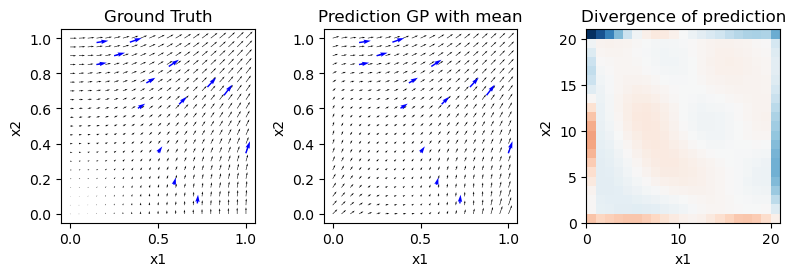

RMSE
0.1961494768657255


In [43]:
fig, axes = plt.subplots(1, 3, figsize = (8, 20))  # 1 rows, 3 columns

training_point_color = "blue" 

# First plot: Ground truth vector field
axes[0].set_title('Ground Truth')
axes[0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black')
axes[0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_aspect('equal')

# Second plot: Divergence-free kernel mean
axes[1].set_title(f"Prediction GP with mean")
axes[1].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_df.detach().numpy()[:, 0], predictive_mean_df.detach().numpy()[:, 1], color = 'black')
axes[1].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].set_aspect('equal')

# Divergence
div = np.gradient(predictive_mean_df[:, 0].reshape(N_grid_x1, N_grid_x2).detach().numpy(), dx, axis = 1) + np.gradient(predictive_mean_df[:, 1].reshape(N_grid_x1, N_grid_x2).detach().numpy(), dy, axis = 0)
print("Inner sum of divergence:")
print(div[1:-1, 1:-1].sum())
color_max = max(abs(np.min(div)), abs(np.max(div)))
color_min = - color_max # So that zero is white

axes[2].set_title(f"Divergence of prediction")
axes[2].pcolormesh(div, cmap = 'RdBu_r', vmin = color_min, vmax = color_max)
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

print("RMSE")
print(torch.sqrt(torch.mean(torch.square(predictive_mean_df - Y_test))).item())

## Understand 2D covar and sample

In [42]:
predictive_covar_df.shape
# predictive_covar_df_reshaped = predictive_covar_df.reshape(N_grid_x1, N_grid_x2, 2, N_grid_x1, N_grid_x2, 2)
# predictive_covar_df_N2N2 = predictive_covar_df_reshaped.reshape(N_grid_x1*N_grid_x2, 2, N_grid_x1*N_grid_x2, 2)
# predictive_covar_df_reshaped = predictive_covar_df.reshape(N_grid_x1*N_grid_x2, 2, N_grid_x1*N_grid_x2, 2)

torch.Size([882, 882])

# Variance-Covariance (4 quandrant diagonals)

- Extracting only the diagonals of the 4 quadrants
- Reduce lengthscale to make it more visible where x_train are

ToDo:
- compare with true variance-covariance

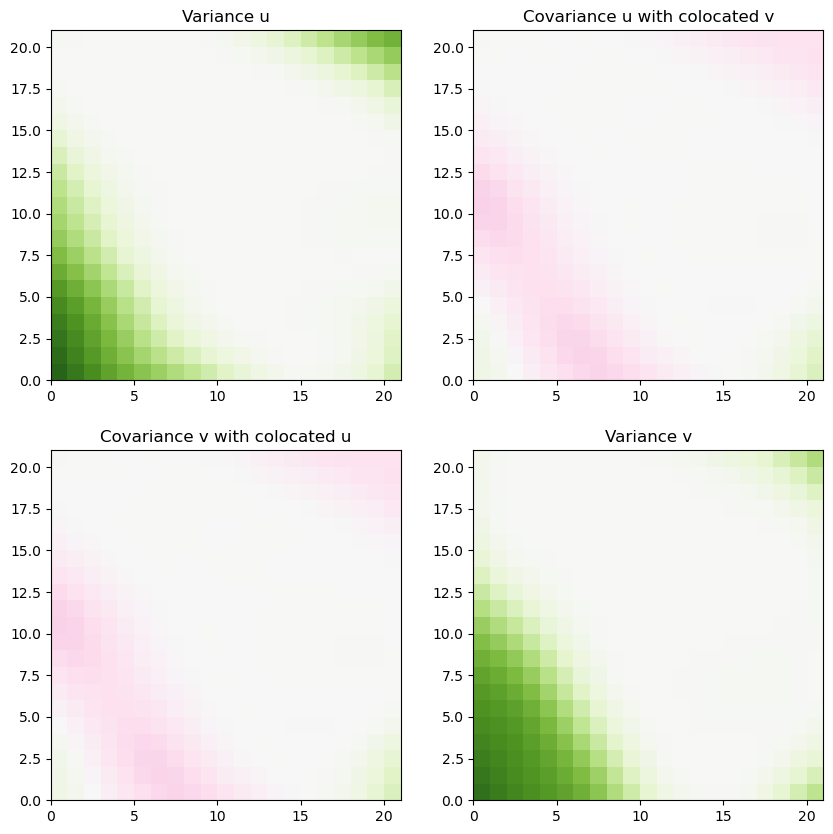

In [33]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))  # 2 rows, 2 columns

color_max = abs(predictive_covar_df).max().item() # (largest absolute value (min or max))
color_min = - color_max # So that zero is white and color scale is symmetric

# Green: positive covariance, pink: negative covariance
axes[0, 0].set_title('Variance u')
axes[0, 0].pcolormesh(torch.diag(predictive_covar_df[:441, :441]).detach().numpy().reshape(21,21), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[0, 0].set_aspect('equal')

axes[0, 1].set_title('Covariance u with colocated v')
axes[0, 1].pcolormesh(torch.diag(predictive_covar_df[:441, 441:]).detach().numpy().reshape(21,21), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[0, 1].set_aspect('equal')

axes[1, 0].set_title('Covariance v with colocated u')
axes[1, 0].pcolormesh(torch.diag(predictive_covar_df[441:, :441]).detach().numpy().reshape(21,21), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[1, 0].set_aspect('equal')

axes[1, 1].set_title('Variance v')
axes[1, 1].pcolormesh(torch.diag(predictive_covar_df[441:, 441:]).detach().numpy().reshape(21,21), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[1, 1].set_aspect('equal')

# Point-to-field covariance for u

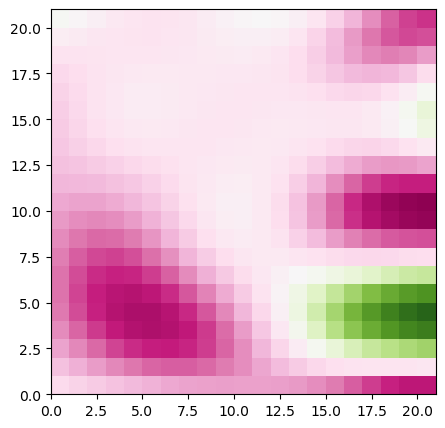

In [366]:
# Upper left quadrant (covaraince matrix of all u with all other u)
# Select one colum (one point in 2 dimensions) and plot the covariance with all other points
predictive_covar_df[:441, :441].detach().numpy()[:, 210].reshape(21, 21)

fig, axes = plt.subplots(1, 1, figsize = (5, 5))

row_from_bottom = 5 # between 0 and 20 (pythonic)
column_from_left = 16 # between 0 and 20 (pythonic)

axes.pcolormesh(
    predictive_covar_df[:441, :441].detach().numpy()[:, ((21 * row_from_bottom) + column_from_left)].reshape(21, 21), 
    cmap = 'PiYG') # 21 so it starts at new row
axes.set_aspect('equal')

plt.show()
# index zero is bottom left corner
# index 20 is bottom right corner

# Show full covariance matrix

- Lower-left and upper-right quadrants would be zero if block diagonal was 0 (no covariance assumed between Y1 an Y2)
- Each column or row in each quadrant would make a 2D grid if reshaped into 2D
- Each quadrant is symmetric (lower left to upper right as origin is ll)

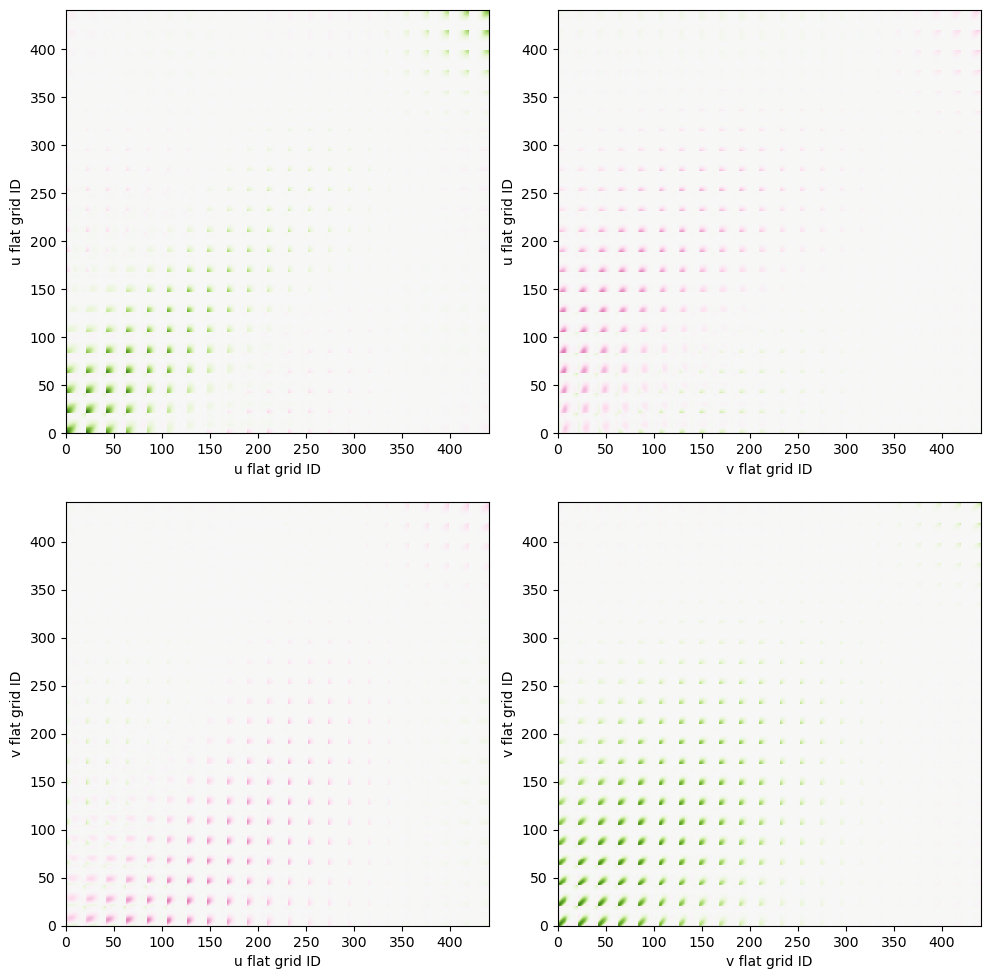

In [370]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))  # 2 rows, 2 columns

color_max = abs(predictive_covar_df).max().item() # (largest absolute value (min or max))
color_min = - color_max # So that zero is white and color scale is symmetric

# Green: positive covariance, pink: negative covariance
axes[0, 0].pcolormesh(predictive_covar_df[:441, :441].detach().numpy(), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[0, 0].set_xlabel('u flat grid ID')
axes[0, 0].set_ylabel('u flat grid ID')
axes[0, 0].set_aspect('equal')

axes[0, 1].pcolormesh(predictive_covar_df[:441, 441:].detach().numpy(), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[0, 1].set_xlabel('v flat grid ID')
axes[0, 1].set_ylabel('u flat grid ID')
axes[0, 1].set_aspect('equal')

axes[1, 0].pcolormesh(predictive_covar_df[441:, :441].detach().numpy(), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[1, 0].set_xlabel('u flat grid ID')
axes[1, 0].set_ylabel('v flat grid ID')
axes[1, 0].set_aspect('equal')

axes[1, 1].pcolormesh(predictive_covar_df[441:, 441:].detach().numpy(), cmap = 'PiYG', vmin = color_min, vmax = color_max)
axes[1, 1].set_xlabel('v flat grid ID')
axes[1, 1].set_ylabel('v flat grid ID')
axes[1, 1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Sample from the Multi-output GP (MOGP) with full covariance function

In [394]:
# Jitter along diagonal
L = torch.linalg.cholesky(predictive_covar_df + 1e-2 * torch.eye(predictive_covar_df.shape[0]))

z = torch.randn(predictive_covar_df.shape[0])

predictive_mean_flat = torch.cat([predictive_mean_df[:, 0].unsqueeze(-1), predictive_mean_df[:, 1].unsqueeze(-1)], dim = 0).flatten()

predictive_mean_flat + L @ z.double()

tensor([    -4.6981,     -2.3813,     -0.1945,      1.7188,      2.7069,
             3.5535,      3.6701,      2.9421,      1.9015,      1.0697,
             0.3356,     -0.3087,     -0.7374,     -1.0049,     -1.2793,
            -1.0814,     -1.0898,     -1.0090,     -0.7484,     -0.6208,
            -0.3669,     -5.4289,     -3.1575,     -0.8761,      0.8281,
             1.9644,      2.4931,      2.3996,      1.9704,      1.3516,
             0.7111,     -0.0160,     -0.3258,     -0.3768,     -0.4605,
            -0.1950,     -0.2395,      0.3353,      0.3784,      0.4890,
             0.8631,      0.9729,     -5.0446,     -3.0955,     -1.1236,
             0.3084,      1.3247,      1.4293,      1.5357,      1.1678,
             0.8476,      0.0236,     -0.0393,     -0.2442,     -0.0706,
             0.2546,      0.5305,      0.8984,      1.0707,      1.3367,
             1.4345,      1.6317,      1.8837,     -4.1873,     -2.2487,
            -0.9983,      0.0308,      0.6190,     

In [391]:
predictive_mean_flat.shape

torch.Size([882, 1])